# NIS800-53 analysis based on the new NLP-based Related Controls

This notebook is the evolution of the [NIS800-53 analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb) notebook and uses the results from the NLP analysis that was done in the [NIS800-53 analysis NLP](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis%20NLP.ipynb) notebook and utilizes the functions written in the [helping_functions](https://github.com/lior0110/regulations_analysis/blob/main/helping_functions.py) file.

The goal of this notebook is to explore how different relationship measures affect the group clustering of the NIS800-53 cybersecurity regulations.
We will take the new relationships measures we have made in the [NIS800-53 analysis NLP](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis%20NLP.ipynb) notebook and do similar analyses to what we have done in the [NIS800-53 analysis notebook](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb) using the functions from the [helping_functions](https://github.com/lior0110/regulations_analysis/blob/main/helping_functions.py) file, we will check and see what the effects of the new relationships measures on the group clustering and discuss if the new relationships measures are a good human-independent relationships measures.

The *"relationship level/threshold"* was chosen to create a comparable number of total connections to human-made relationships.

Four new unsupervised clustering measures where added: Silhouette Score, Calinski Harabasz Score, Davies Bouldin Score and Dunn Score.

In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import networkx as nx

import google.generativeai as genai
from google.api_core import retry

import os
import time
import xlsxwriter

# import all the helping functions that were written in the base NIS800-53 analysis notebook
from helping_functions import *


# Read the NIS800-53 regulations with the new NLP-based related controls

In [2]:

# NIS_regulations = pd.read_excel("regulations//sp800-53r5-control-catalog.xlsx")
# NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls.feather")
# NIS_regulations = pd.read_parquet("regulations//Active_NIS_regulations_with_new_related_controls.parquet")
# # Constructed so any of the new "related controls" columns will give a similar number of connections to the default "related controls"
# NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls2L.feather")
# NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls2.feather")
# Constructed so the combination of the new "related controls" columns will give a similar number of connections to the default "related controls"
# NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls2M.feather")
NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls2M+1.feather")
# NIS_regulations = pd.read_feather("regulations//Active_NIS_regulations_with_new_related_controls2M+2.feather")
NIS_regulations

# remove every key with None value for the new relations columns and sort them from highest to lowest

NIS_regulations.loc[:, "bm25 Related Controls"] = NIS_regulations.loc[:, "bm25 Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None}).apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))
NIS_regulations.loc[:, "normalized bm25 Related Controls"] = NIS_regulations.loc[:, "normalized bm25 Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None}).apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

NIS_regulations.loc[:, "SentenceTransformer Related Controls"] = NIS_regulations.loc[:, "SentenceTransformer Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None}).apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

NIS_regulations.loc[:, "SaaS Related Controls"] = NIS_regulations.loc[:, "SaaS Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None}).apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))
# NIS_regulations.loc[:, "bm25 Related Controls"] = NIS_regulations.loc[:, "bm25 Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None})
# NIS_regulations.loc[:, "normalized bm25 Related Controls"] = NIS_regulations.loc[:, "normalized bm25 Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None})
# NIS_regulations.loc[:, "SentenceTransformer Related Controls"] = NIS_regulations.loc[:, "SentenceTransformer Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None})
# NIS_regulations.loc[:, "SaaS Related Controls"] = NIS_regulations.loc[:, "SaaS Related Controls"].apply(lambda x: {k: v for k, v in x.items() if v is not None})

NIS_regulations


,Control Identifier,Control (or Control Enhancement) Name,Control Text,Discussion,Related Controls,Main Control Name,Family Name,Related Controls Dictionary,Full Text,bm25 Related Controls,normalized bm25 Related Controls,SentenceTransformer Related Controls,SaaS Related Controls
0,AC-1,Policy and Procedures,"a. Develop, document, and disseminate to [Assi...",Access control policy and procedures address t...,"IA-1, PM-9, PM-24, PS-8, SI-12 .",AC-1,AC,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...","Policy and Procedures\n\na. Develop, document,...","{'MA-1': 59.27978515625, 'PL-1': 59.2797851562...","{'MA-1': 0.8947177027189795, 'PL-1': 0.8947177...","{'PS-1': 0.9554650783538818, 'CA-1': 0.9547804...","{'CA-1': 0.9555830106820367, 'SC-1': 0.9506337..."
1,AC-2,Account Management,a. Define and document the types of accounts a...,Examples of system account types include indiv...,"AC-3, AC-5, AC-6, AC-17, AC-18, AC-20, AC-24, ...",AC-2,AC,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Account Management\n\na. Define and document t...,"{'AC-2(3)': 63.61791229248047, 'AC-2(7)': 62.1...","{'AC-2(3)': 0.5456564097423026, 'AC-2(7)': 0.5...","{'AC-2(7)': 0.8722906112670898, 'AC-2(11)': 0....","{'AC-2(7)': 0.8690222363681739, 'AC-2(11)': 0...."
2,AC-2(1),Account Management | Automated System Account ...,Support the management of system accounts usin...,Automated system account management includes u...,None.,AC-2,AC,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Account Management | Automated System Account ...,"{'AC-2(2)': 13.920116424560547, 'AC-2(8)': 13....","{'AC-2(2)': 0.6856685718365872, 'AC-2(8)': 0.6...","{'AC-2(8)': 0.8399572968482971, 'IR-4(1)': 0.8...","{'AC-2(8)': 0.8385143606316967, 'AC-2(11)': 0...."
3,AC-2(2),Account Management | Automated Temporary and E...,Automatically [Selection: remove; disable] tem...,Management of temporary and emergency accounts...,None.,AC-2,AC,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Account Management | Automated Temporary and E...,"{'AC-2(4)': 18.166128158569336, 'AC-2(3)': 16....","{'AC-2(4)': 0.4500737751259309, 'AC-2(3)': 0.4...","{'AC-2(3)': 0.8158748745918274, 'AC-2(4)': 0.8...","{'AC-2(3)': 0.8327054165938192, 'AC-2(13)': 0...."
4,AC-2(3),Account Management | Disable Accounts,Disable accounts within [Assignment: organizat...,"Disabling expired, inactive, or otherwise anom...",None.,AC-2,AC,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Account Management | Disable Accounts\n\nDisab...,"{'AC-2(13)': 23.608457565307617, 'AC-2(2)': 20...","{'AC-2(13)': 0.5667917968522473, 'AC-2(2)': 0....","{'AC-2(13)': 0.8616950511932373, 'AC-2(5)': 0....","{'AC-2(13)': 0.8635755082149525, 'AC-2(2)': 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,SR-11,Component Authenticity,a. Develop and implement anti-counterfeit poli...,Sources of counterfeit components include manu...,"PE-3, SA-4, SI-7, SR-9, SR-10.",SR-11,SR,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Component Authenticity\n\na. Develop and imple...,"{'SR-11(1)': 28.72646141052246, 'SR-11(3)': 26...","{'SR-11(1)': 0.6496216599515963, 'SR-11(3)': 0...","{'SR-11(1)': 0.8409212231636047, 'SR-11(3)': 0...","{'SR-11(1)': 0.8345096504298886, 'CM-8(3)': 0...."
1185,SR-11(1),Component Authenticity | Anti-counterfeit Trai...,Train [Assignment: organization-defined person...,None.,AT-3.,SR-11,SR,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Component Authenticity | Anti-counterfeit Trai...,"{'SR-11': 17.0235538482666, 'SR-11(3)': 15.025...","{'SR-11': 0.6172898806384338, 'SR-11(3)': 0.54...","{'SR-11(3)': 0.8443235158920288, 'SR-11': 0.84...","{'SR-11(3)': 0.8393997564526279, 'SR-11': 0.83..."
1186,SR-11(2),Component Authenticity | Configuration Control...,Maintain configuration control over the follow...,None.,"CM-3, MA-2, MA-4, SA-10.",SR-11,SR,"{'AC-1': None, 'AC-10': None, 'AC-11': None, '...",Component Authenticity | Configuration Control...,{'SA-4(5)': 16.491981506347656},{'SA-4(5)': 0.3748

In [3]:

family_column = "Family Name"

# group by family name and count the number of regulations in each family
NIS_regulations.groupby(by=[family_column]).apply(len,include_groups=False).mean()
# now interquntile



50.35

In [4]:

NIS_regulations.loc[1,"normalized bm25 Related Controls"]
# NIS_regulations.loc[1,["bm25 Related Controls","normalized bm25 Related Controls","SentenceTransformer Related Controls","SaaS Related Controls"]]
# NIS_regulations.loc[0,"bm25 Related Controls"].keys()
# type(NIS_regulations.loc[0,"bm25 Related Controls"])

# print all key value pairs in NIS_regulations.loc[1,"normalized bm25 Related Controls"]
for k, v in NIS_regulations.loc[1,"normalized bm25 Related Controls"].items():
    print(f"{k}: {v}")
    print("-"*80)
    




AC-2(3): 0.5456564097423026
--------------------------------------------------------------------------------
AC-2(7): 0.5332102684763498
--------------------------------------------------------------------------------
AC-2(9): 0.5220074162177839
--------------------------------------------------------------------------------
AC-2(12): 0.5073050386463656
--------------------------------------------------------------------------------
AC-2(2): 0.497907489534503
--------------------------------------------------------------------------------
AC-2(13): 0.4820235309761175
--------------------------------------------------------------------------------
IA-2(5): 0.4703392514575003
--------------------------------------------------------------------------------
IA-5: 0.46017980787930934
--------------------------------------------------------------------------------
AC-2(8): 0.4444947807971446
--------------------------------------------------------------------------------
AC-6(2): 0.441447301

## transform the old Related Controls from the string NIS representation to the new Dictionary representation

In [5]:

# Related_Controls = row["Related Controls"].replace(" .","").replace(".","").split(", ")
# apply the replace and split operation on the Related Controls column to get a list of related controls
# NIS_regulations["Related Controls"].apply(lambda x: {k: v for k, v in (i.split("-") for i in x.replace(" .","").replace(".","").split(", ")) if v is not None else None })
new_NIS_Related_Controls = NIS_regulations["Related Controls"].apply(lambda x: x.replace(" .","").replace(".","").split(", "))
# transform the list of related controls into a dictionary where the key is the control and the value is 0.5
# new_NIS_Related_Controls[3]
# {x: 0.5 for x in new_NIS_Related_Controls[0] if x != "None"}
new_NIS_Related_Controls = new_NIS_Related_Controls.apply(lambda x: {k: 0.5 for k in x if k!= "None"})
NIS_regulations["Related Controls Dictionary"] = new_NIS_Related_Controls

new_NIS_Related_Controls


0       {'IA-1': 0.5, 'PM-9': 0.5, 'PM-24': 0.5, 'PS-8...
1       {'AC-3': 0.5, 'AC-5': 0.5, 'AC-6': 0.5, 'AC-17...
2                                                      {}
3                                                      {}
4                                                      {}
                              ...                        
1184    {'PE-3': 0.5, 'SA-4': 0.5, 'SI-7': 0.5, 'SR-9'...
1185                                        {'AT-3': 0.5}
1186    {'CM-3': 0.5, 'MA-2': 0.5, 'MA-4': 0.5, 'SA-10...
1187                                        {'RA-5': 0.5}
1188                                        {'MP-6': 0.5}
Name: Related Controls, Length: 1007, dtype: object

# Checking the "Related Controls" column

We want to know what the statistics are of all of the Related Controls columns (the original column and the new columns we have made).

## Run describe on the "Related Controls" column

In [6]:
NIS_regulations.loc[:,["Related Controls Dictionary","bm25 Related Controls","normalized bm25 Related Controls","SentenceTransformer Related Controls","SaaS Related Controls"]].describe(include="all")

,Related Controls Dictionary,bm25 Related Controls,normalized bm25 Related Controls,SentenceTransformer Related Controls,SaaS Related Controls
count,1007,1007,1007,1007,1007
unique,540,1007,1007,1007,1007
top,{},"{'MA-1': 59.27978515625, 'PL-1': 59.2797851562...","{'MA-1': 0.8947177027189795, 'PL-1': 0.8947177...","{'PS-1': 0.9554650783538818, 'CA-1': 0.9547804...","{'CA-1': 0.9555830106820367, 'SC-1': 0.9506337..."
freq,361,1,1,1,1


We can see that like in the human-made relations there are still some regulations that have no related controls.

## Look if the controls are mutually related
Two controls will be considered mutually related if control A or any of its sub-controls is related to control B or any of its sub-controls and control B or any of its sub-controls are also related to control A or any of its sub-controls.

We assume that related controls should be mutually related because there is no reason that if control A is related to control B control B will not be related to control A.

In order to check the mutual relations status and get relations statistics we will use the **'get_mutual_relations'** function from the **helping_functions**



In [7]:

relations_columns = ["Related Controls Dictionary","bm25 Related Controls","normalized bm25 Related Controls","SentenceTransformer Related Controls","SaaS Related Controls"]

# get the statistics for every individual relationship method
for relation_column in relations_columns:
    mutually_related, not_mutually_related, in_family_connection_statistics, relations_statistics = get_mutual_relations(NIS_regulations,relation_column,do_print=False)
    print(f'there are {len(not_mutually_related)} non-mutual connections in "{relation_column}"')
    print(f"in-family connections:\n{in_family_connection_statistics}")
    # print(f"Relations statistics:\n{relations_statistics}")
    s_r = sum(mutually_related["same family"]) / len(mutually_related)
    if len(not_mutually_related) > 0:
        s_r_n = sum(not_mutually_related["same family"]) / len(not_mutually_related)
    else:
        s_r_n = 0
    s = (sum(mutually_related["same family"]) + sum(not_mutually_related["same family"])) / (len(mutually_related) + len(not_mutually_related))
    print(f"{s:.2%} of existing connections are in-family")
    print(f"{s_r:.2%} of existing mutual connections are in-family")
    print(f"{s_r_n:.2%} of existing non-mutual connections are in-family")
    print("-"*100)
    

# get the statistics for a combination of the three human-independent relationship method (excluding the un-normalized bm25 Related Controls)
mutually_related, not_mutually_related, in_family_connection_statistics, relations_statistics = get_mutual_relations(NIS_regulations,relations_columns[2:],do_print=False)

print(f'there are {len(not_mutually_related)} non-mutual connections in "{relations_columns[2:]}"')
print(f"in-family connections:\n{in_family_connection_statistics}")
# print(f"Relations statistics:\n{relations_statistics}")
s_r = sum(mutually_related["same family"]) / len(mutually_related)
if len(not_mutually_related) > 0:
    s_r_n = sum(not_mutually_related["same family"]) / len(not_mutually_related)
else:
    s_r_n = 0
s = (sum(mutually_related["same family"]) + sum(not_mutually_related["same family"])) / (len(mutually_related) + len(not_mutually_related))
print(f"{s:.2%} of existing connections are in-family")
print(f"{s_r:.2%} of existing mutual connections are in-family")
print(f"{s_r_n:.2%} of existing non-mutual connections are in-family")
print("-"*100)



there are 645 non-mutual connections in "Related Controls Dictionary"
in-family connections:
number of families                                                                                                     20.000000
mean number of controls in family                                                                                      14.900000
median number of controls in family                                                                                    12.000000
std of number of controls in family                                                                                    10.187195
Inter-quartile range of number of controls in family                                                                    9.500000
number of participating controls                                                                                      298.000000
balance score 1 (mean/std)(higher better)                                                                               1.462620
bala

For the related controls we got from "bm25 Related Controls", we see a lot of non-mutual connections, 1567 compared to 645 from the human-made relations. This may be because the BM25 score function is not commutative so the distance from control A to control B is not the same as from control B to control A. Apart from that, the non-normalized bm25 scores look different from all the other tested methods, and it gives worse statistical indicators than them and the human-made relations.

For the related controls we got from "normalized bm25 Related Controls", we see some non-mutual connections, 1014 compared to 645 from the human-made relations. This is probably due to the score normalization step we used.

For the related controls we got from "SentenceTransformer Related Controls" and "SaaS Related Controls" we got 0 non-mutual connections. This is because the scores from them are normalized by default and because they are commutative so the distance from control A to control B is the same as from control B to control A.

Furthermore (Apart from the "bm25 Related Controls" scores), the statistics of the in-family connections are all on similar levels to what we got from the human-made relations for the three individual human-independent relationship method. 

The combination of the three individual human-independent relationship methods, "normalized bm25 Related Controls, "SentenceTransformer Related Controls," and "SaaS Related Controls," gives a similar number of non-mutual connections to the human-made connections, 675 compared to 645.
The combined result also shows more than 60% more connections than the individual methods, saying that the connections from the three individual human-independent relationship methods do not completely overlap but still have some base similarities.

The statistical indicators of the combined result are lower than the human-made baseline, which may be expected because of the results we saw in the first analysis [NIS800-53 analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb).
But combined with the statistical indicators of the individual human-independent relationship method being similar to the human-made baseline, may say that each one of the three human-independent relationship methods see small aspects that the other two methods don't see.

# Make a network graph based on the "Related Controls" column/s


## Recreate the results from the previous NIS800-53 analysis

We will start by using the original "Related Controls" column in the new pipeline with the new functions in order to see that we get similar results to what we got in the first analysis [NIS800-53 analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb).

number of nodes in graph: 298
number of edges in graph: 0
number of nodes in graph: 298
number of edges in graph: 0
number of nodes in graph: 298
number of edges in graph: 1906
number of connected components: 6
component 0 has 293 nodes
component 1 has 1 nodes
{'AT-6'}
component 2 has 1 nodes
{'MP-8'}
component 3 has 1 nodes
{'SC-51'}
component 4 has 1 nodes
{'SI-22'}
component 5 has 1 nodes
{'SI-23'}
----------------------------------------------------------------------------------------------------
base NIS800-53 families:
the in_family_connection_ratios are: 0.248 , 0.232
number of families                                                                                                     20.000000
mean number of controls in family                                                                                      14.900000
median number of controls in family                                                                                    12.000000
std of number of controls in fa

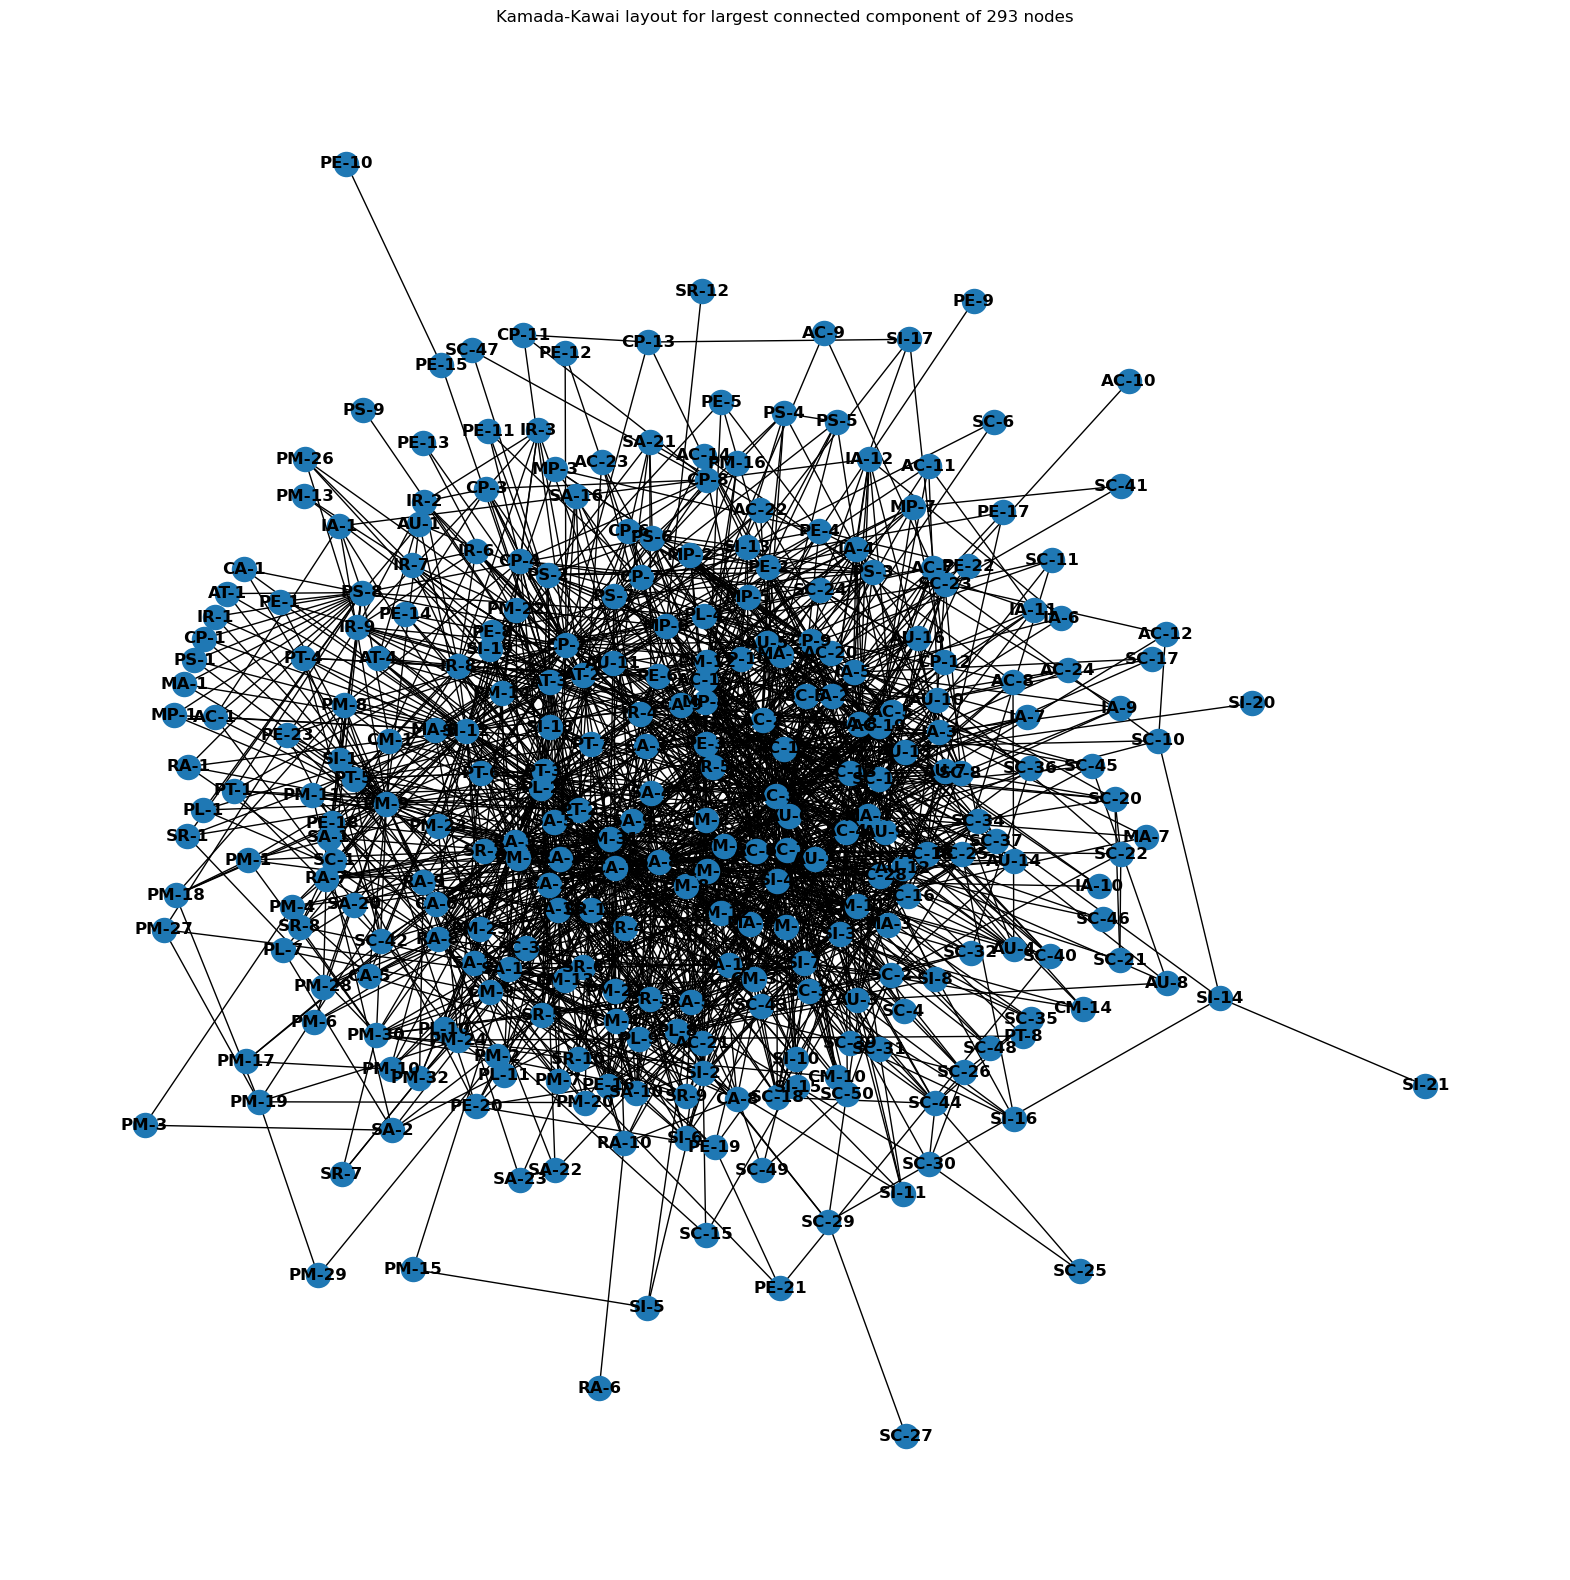

In [8]:

relations_columns = ["Related Controls Dictionary","bm25 Related Controls","normalized bm25 Related Controls","SentenceTransformer Related Controls","SaaS Related Controls"]

is_directed:bool = False
is_Main_Controls_Only:bool = True
is_Weighted:bool = True

add_groups_summaries:bool = False

i:int=1
Relations = relations_columns[0] # use the original "Related Controls" column

Related_Controls_Graph = make_network_graph_from_relations(NIS_regulations, Relations, 
                                                           is_directed=is_directed, is_Main_Controls_Only=is_Main_Controls_Only, is_Weighted=is_Weighted)
if is_directed:
    strongly_connected_components, weakly_connected_components = inspect_connected_components(Related_Controls_Graph, draw_kamada_kawai=True)
    in_family_connection_statistics_test, relations_DataFrames, NIS_regulations_old = cluster_analysis(Related_Controls_Graph.subgraph(weakly_connected_components[0]),
                                                                                  NIS_regulations,Relations,Is_Weighted=is_Weighted,Only_Main_Controls=is_Main_Controls_Only,
                                                                                  add_groups_summaries=add_groups_summaries,
                                                                                  do_Modularity_based_communities=True, do_Louvain_communities=True, do_Fluid_communities=True,
                                                                                  do_Divisive_communities=True, do_Label_propagation_communities=True, do_Centrality_communities=True,
                                                                                  )

else:
    connected_components = inspect_connected_components(Related_Controls_Graph, draw_kamada_kawai=True)
    in_family_connection_statistics_test, relations_DataFrames, NIS_regulations_old = cluster_analysis(Related_Controls_Graph.subgraph(connected_components[0]),
                                                                                  NIS_regulations,Relations,Is_Weighted=is_Weighted,Only_Main_Controls=is_Main_Controls_Only,
                                                                                  add_groups_summaries=add_groups_summaries,
                                                                                  do_Modularity_based_communities=True, do_Louvain_communities=True, do_Fluid_communities=True,
                                                                                  do_Divisive_communities=True, do_Label_propagation_communities=True, do_Centrality_communities=True,
                                                                                  )

    in_family_connection_statistics_test





In [9]:

in_family_connection_statistics_test
relations_DataFrames[1]



,number of regulations,names of regulations,possible inside relations,actual inside relations,percentage inside relations,possible outside relations,actual outside relations,percentage outside relations,inner connections probability,mean dist from family to all,median dist from family to all,mean dist in family,median dist in family
Modularity_based_communities,,,,,,,,,,,,,
0.0,78,"[AC-10, AC-19, AU-9, AU-10, CM-2, CM-3, CM-4, ...",6006,595,0.099068,16770,400,0.023852,0.59799,0.669546,0.666667,0.599362,0.600000
1.0,71,"[AC-2, AC-3, AC-4, AC-5, AC-6, AC-7, AC-8, AC-...",4970,520,0.104628,15762,337,0.021381,0.606768,0.669798,0.666667,0.573056,0.500000
2.0,71,"[AT-2, AT-3, AT-4, CA-2, CA-5, CA-6, CA-7, CA-...",4970,491,0.098793,15762,376,0.023855,0.566321,0.693863,0.696429,0.635099,0.666667
3.0,51,"[AC-1, AC-23, AT-1, AU-1, CA-1, CM-1, CM-12, C...",2550,160,0.062745,12342,172,0.013936,0.481928,0.766782,0.750000,0.700026,0.750000
4.0,9,"[AC-25, SC-2, SC-3, SC-11, SC-32, SC-39, SC-49...",72,24,0.333333,2556,39,0.015258,0.380952,0.689681,0.666667,0.463992,0.500000
5.0,7,"[PE-18, PE-19, PE-20, PE-21, PE-23, PM-8, SC-40]",42,12,0.285714,2002,22,0.010989,0.352941,0.781357,0.750000,0.552041,0.500000
6.0,6,"[SC-25, SC-27, SC-29, SC-30, SI-14, SI-21]",30,10,0.333333,1722,9,0.005226,0.526316,0.879115,0.883333,0.430556,0.500000


In [10]:


with pd.ExcelWriter('regulations outputs\\in family connection statistics test old.xlsx') as writer:  
    in_family_connection_statistics_test.to_excel(writer, sheet_name="methods comparison",merge_cells=False,freeze_panes=(1,1))
    workbook = writer.book
    worksheet = writer.sheets['methods comparison']

    format1 = workbook.add_format({"num_format": "#,##0.###"})
    worksheet.set_column(0, 0, 56, None)
    worksheet.set_column(1, 100, None, format1)
    
    max_color_rows:list[int] = [8, 9, 12, 13, 18, 19, 20, 21, 22, 23, 24, 27, 28, ]
    for i in max_color_rows:
        worksheet.conditional_format(f'$A${str(i)}:$L${str(i)}', {'type': '3_color_scale',
                                                'min_color': '#F8696B', # red
                                                'min_type': 'min',
                                                'mid_color': '#FFFFFF', # white
                                                'mid_type': 'formula',
                                                'mid_value': f'=$B${str(i)}',
                                                'max_color': '#63BE7B', # green
                                                'max_type': 'max',})
    min_color_rows:list[int] = [25, 26, ]
    for i in min_color_rows:
        worksheet.conditional_format(f'$A${str(i)}:$L${str(i)}', {'type': '3_color_scale',
                                                'min_color': '#63BE7B', # green
                                                'min_type': 'min',
                                                'mid_color': '#FFFFFF', # white
                                                'mid_type': 'formula',
                                                'mid_value': f'=$B${str(i)}',
                                                'max_color': '#F8696B', # red
                                                'max_type': 'max',})
        

    for i in range(len(relations_DataFrames)) :
        relations_DataFrames[i].to_excel(writer, sheet_name=relations_DataFrames[i].index.name, merge_cells=False, freeze_panes=(1,1))
    # NIS_relations_statistics.to_excel(writer, sheet_name="original NIS statistics",merge_cells=False,freeze_panes=(1,1))
    # Modularity_based_communities_relations_statistics.to_excel(writer, sheet_name="Modularity statistics",merge_cells=False,freeze_panes=(1,1))
    # Louvain_Communities_relations_statistics.to_excel(writer, sheet_name="Louvain statistics",merge_cells=False,freeze_panes=(1,1))
    # Fluid_Communities_relations_statistics.to_excel(writer, sheet_name="Fluid statistics",merge_cells=False,freeze_panes=(1,1))

in_family_connection_statistics_test


,NIS800-53 families,Modularity based communities,Louvain Communities,Fluid Communities,Divisive Communities,Label propagation,Centrality Communities
number of families,20.000000,7.000000,7.000000,20.000000,20.000000,2.000000,20.000000
mean number of controls in family,14.900000,41.857143,41.857143,14.650000,14.650000,146.500000,14.650000
median number of controls in family,12.000000,51.000000,44.000000,15.500000,2.000000,146.500000,1.000000
std of number of controls in family,10.187195,33.338809,16.190826,5.183730,50.239715,204.353860,59.869397
Inter-quartile range of number of controls in family,9.500000,63.000000,14.500000,5.500000,3.000000,144.500000,1.000000
number of participating controls,298.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
balance score 1 (mean/std)(higher better),1.462620,1.255508,2.585238,2.826150,0.291602,0.716894,0.244699
balance score 2 (median/Inter-quartile range)(higher better),1.263158,0.809524,3.034483,2.818182,0.666667,1.013841,1.000000
same family connections,785.000000,1812.000000,1647.000000,1130.000000,2872.000000,3165.000000,3109.000000
out of family connections,2382.000000,1355.000000,1520.000000,2037.000000,295.000000,2.000000,58.000000


In [11]:


relations_DataFrames[0].index.name

families = NIS_regulations.groupby(by=["Family Name"]) # pre-group families
# get number of distinct controls in the family
families['Main Control Name'].nunique()
num_Controls_in_family = families.apply(len,include_groups=False)

num_Controls_in_family


Family Name
AC    131
AT     15
AU     56
CA     25
CM     56
CP     49
IA     55
IR     40
MA     28
MP     20
PE     51
PL     11
PM     37
PS     17
PT     21
RA     22
SA    106
SC    139
SI    101
SR     27
dtype: int64

Similar to conclusions from the first analysis [NIS800-53 analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb) ***Communities conclusion*** sub-section:
* "Divisive Communities" "Label propagation" and "Centrality Communities" gives us very unbalanced new families that we don't want 
* "Modularity based communities" gives exactly the same results, but now we can see that the new families may be not balanced like we would have wanted, but it beats the original NIS families in all of the new unsupervised clustering measures.
* "Louvain Communities" having a random element gives similar but not exactly the same results, having better **empiric connection probabilities** scores then the default families and always having better score at **statistical connection probability 1 (Over-representation of total inner connections)** and having close **statistical connection probability 2 (Over-representation of mean inner connections)** and **statistical connection probability 3 (mean of Over-representation of inner connections per family)** scores to the default families (sometimes a little more sometimes a little less), but we can also see that its balance scores are better than the default families, and in the new unsupervised clustering measures it only sometime losses in the **graph davies bouldin score mean** by a little.
* "Fluid Communities" having a random element gives similar but not exactly the same results, but like in the previous analysis gives better **empiric connection probabilities** and **statistical connection probabilities** scores than the default families, and we can also see that its balance scores are better than the default families. And in the new unsupervised clustering measures it beats the original NIS families in **Silhouette Score**, **Calinski Harabasz Score**, **Davies Bouldin Score**, but gives similar scores for **Dunn Score**.


After seeing that the pipeline works ok by recreating the original analysis results, we can move on to run the pipeline on the new NLP based "Related Controls" columns we have created.

## Calculate Clustering from new NLP-based "Related Controls" columns

Now we will choose the subset of the NLP-based "Related Controls" columns we have created and run the pipeline based on them.

number of nodes in graph: 298
number of edges in graph: 0
number of nodes in graph: 298
number of edges in graph: 0
number of nodes in graph: 298
number of edges in graph: 1875
number of connected components: 1
component 0 has 298 nodes
----------------------------------------------------------------------------------------------------
base NIS800-53 families:
the in_family_connection_ratios are: 0.269 , 0.258
number of families                                                                                                     20.000000
mean number of controls in family                                                                                      14.900000
median number of controls in family                                                                                    12.000000
std of number of controls in family                                                                                    10.187195
Inter-quartile range of number of controls in family                  

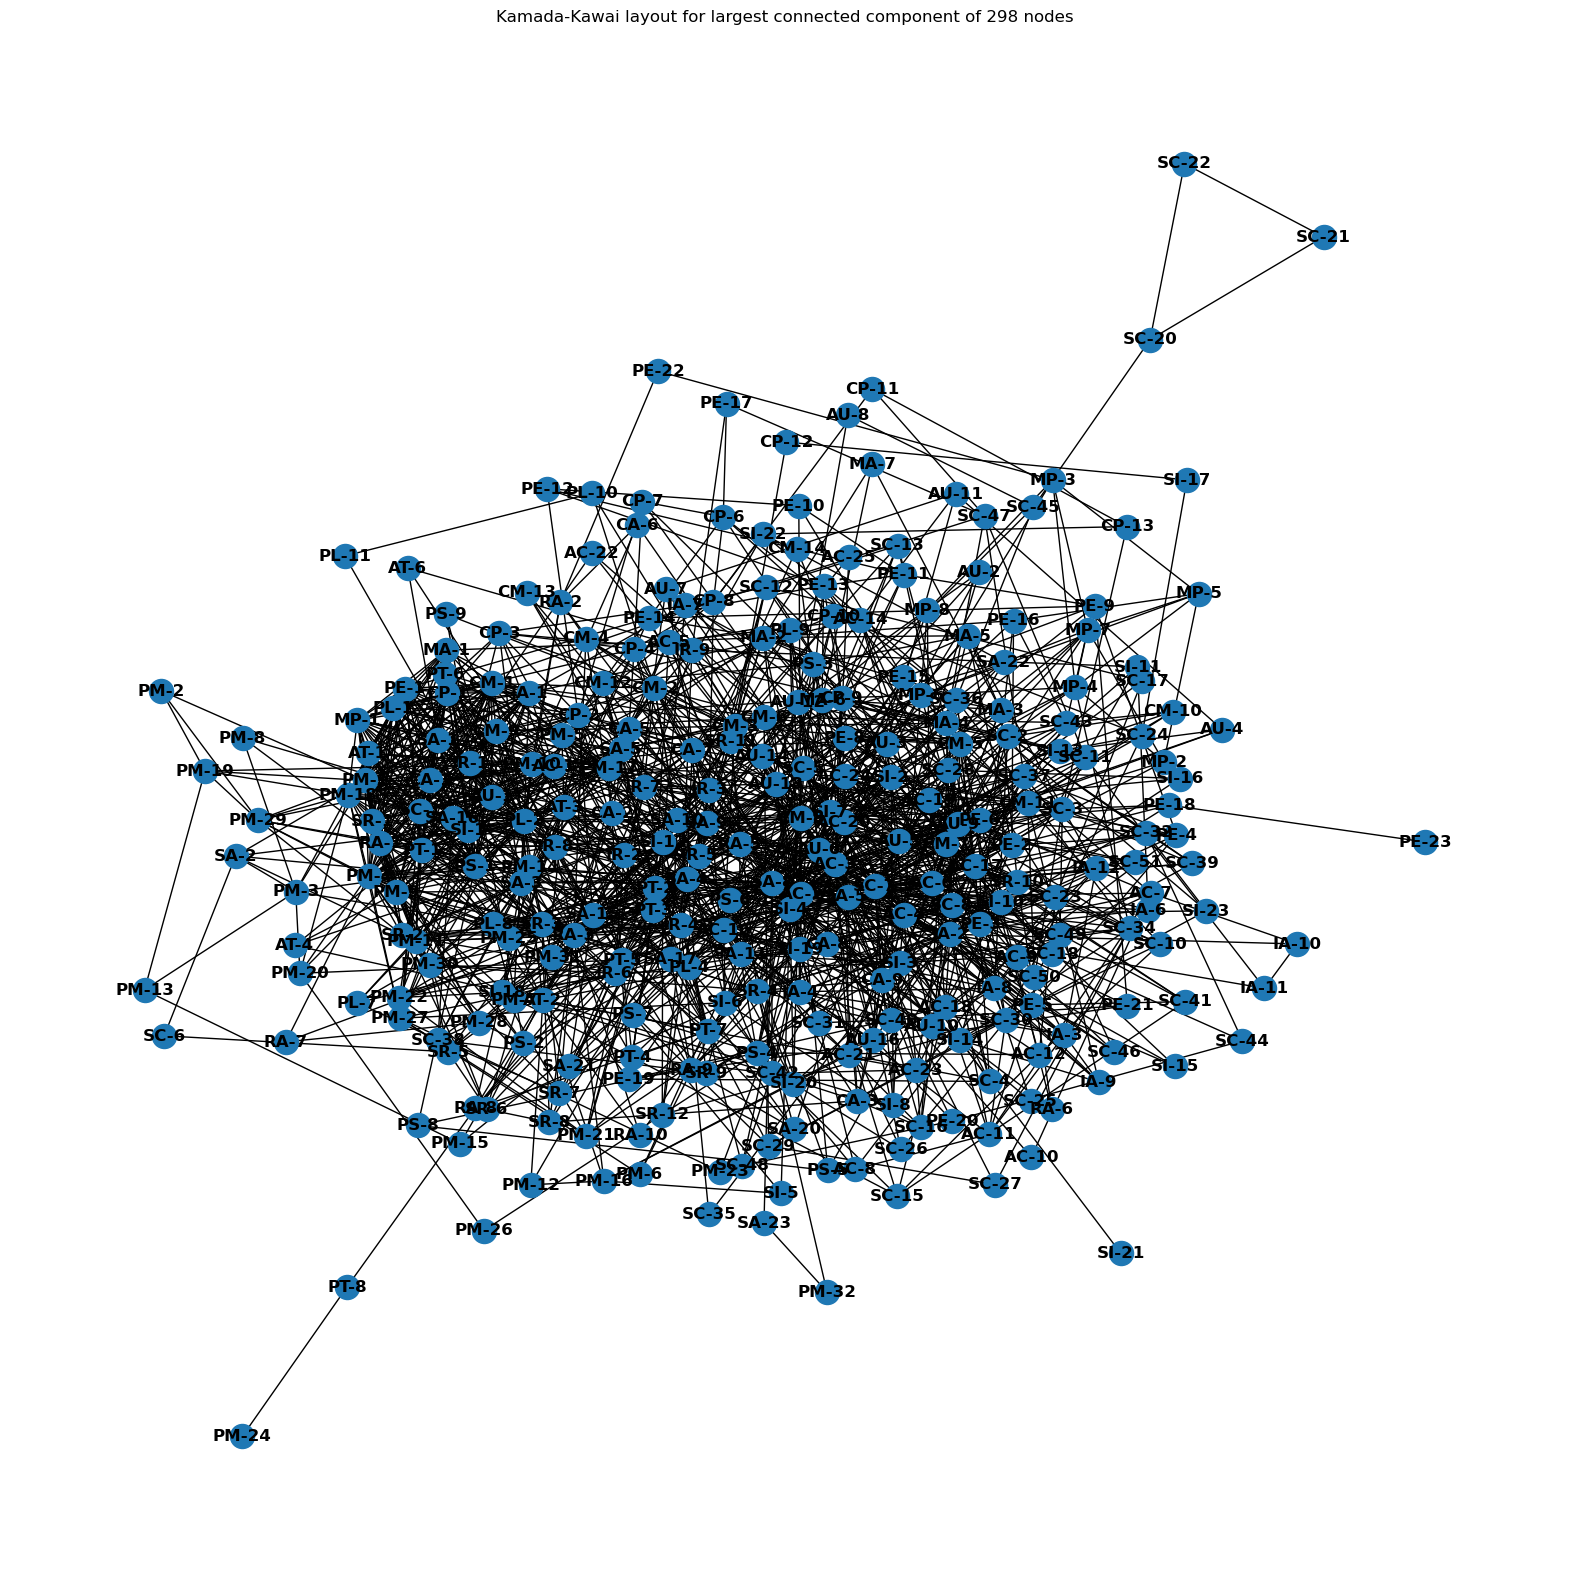

In [12]:

relations_columns = ["Related Controls Dictionary","bm25 Related Controls","normalized bm25 Related Controls","SentenceTransformer Related Controls","SaaS Related Controls"]

is_directed:bool = False
is_Main_Controls_Only:bool = True
is_Weighted:bool = True

add_groups_summaries:bool = False

i:int=1
Relations = relations_columns[2:] # use the original "Related Controls" column

Related_Controls_Graph = make_network_graph_from_relations(NIS_regulations, Relations, 
                                                           is_directed=is_directed, is_Main_Controls_Only=is_Main_Controls_Only, is_Weighted=is_Weighted)
if is_directed:
    strongly_connected_components, weakly_connected_components = inspect_connected_components(Related_Controls_Graph, draw_kamada_kawai=True)
    in_family_connection_statistics_test, relations_DataFrames, NIS_regulations_new = cluster_analysis(Related_Controls_Graph.subgraph(weakly_connected_components[0]),
                                                                                  NIS_regulations,Relations,Is_Weighted=is_Weighted,Only_Main_Controls=is_Main_Controls_Only,
                                                                                  add_groups_summaries=add_groups_summaries,
                                                                                  do_Modularity_based_communities=True, do_Louvain_communities=True, do_Fluid_communities=True,
                                                                                  do_Divisive_communities=True, do_Label_propagation_communities=True, do_Centrality_communities=True,
                                                                                  )

else:
    connected_components = inspect_connected_components(Related_Controls_Graph, draw_kamada_kawai=True)
    in_family_connection_statistics_test, relations_DataFrames, NIS_regulations_new = cluster_analysis(Related_Controls_Graph.subgraph(connected_components[0]),
                                                                                  NIS_regulations,Relations,Is_Weighted=is_Weighted,Only_Main_Controls=is_Main_Controls_Only,
                                                                                  add_groups_summaries=add_groups_summaries,
                                                                                  do_Modularity_based_communities=True, do_Louvain_communities=True, do_Fluid_communities=True,
                                                                                  do_Divisive_communities=True, do_Label_propagation_communities=True, do_Centrality_communities=True,
                                                                                  )

    in_family_connection_statistics_test





In [13]:
in_family_connection_statistics_test
# relations_DataFrames[0]

,NIS800-53 families,Modularity based communities,Louvain Communities,Fluid Communities,Divisive Communities,Label propagation,Centrality Communities
number of families,20.000000,9.000000,10.000000,20.000000,20.000000,5.000000,20.000000
mean number of controls in family,14.900000,33.111111,29.800000,14.900000,14.900000,59.600000,14.900000
median number of controls in family,12.000000,39.000000,31.000000,14.500000,8.500000,2.000000,2.000000
std of number of controls in family,10.187195,17.856683,10.716550,4.822098,20.349318,128.239230,58.405029
Inter-quartile range of number of controls in family,9.500000,23.000000,14.500000,5.000000,9.500000,1.000000,1.000000
number of participating controls,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
balance score 1 (mean/std)(higher better),1.462620,1.854270,2.780746,3.089941,0.732211,0.464756,0.255115
balance score 2 (median/Inter-quartile range)(higher better),1.263158,1.695652,2.137931,2.900000,0.894737,2.000000,2.000000
same family connections,847.000000,1137.000000,992.000000,1493.000000,1745.000000,3121.000000,3063.000000
out of family connections,2307.000000,2017.000000,2162.000000,1661.000000,1409.000000,33.000000,91.000000


In [14]:

with pd.ExcelWriter('regulations outputs\\in family connection statistics test new NLP based.xlsx', engine='xlsxwriter') as writer:  
    in_family_connection_statistics_test.to_excel(writer, sheet_name="methods comparison",merge_cells=False,freeze_panes=(1,1))
    workbook = writer.book
    worksheet = writer.sheets['methods comparison']

    format1 = workbook.add_format({"num_format": "#,##0.###"})
    worksheet.set_column(0, 0, 56, None)
    worksheet.set_column(1, 100, None, format1)
    
    max_color_rows:list[int] = [8, 9, 12, 13, 18, 19, 20, 21, 22, 23, 24, 27, 28, ]
    for i in max_color_rows:
        worksheet.conditional_format(f'$A${str(i)}:$L${str(i)}', {'type': '3_color_scale',
                                                'min_color': '#F8696B', # red
                                                'min_type': 'min',
                                                'mid_color': '#FFFFFF', # white
                                                'mid_type': 'formula',
                                                'mid_value': f'=$B${str(i)}',
                                                'max_color': '#63BE7B', # green
                                                'max_type': 'max',})
    min_color_rows:list[int] = [25, 26, ]
    for i in min_color_rows:
        worksheet.conditional_format(f'$A${str(i)}:$L${str(i)}', {'type': '3_color_scale',
                                                'min_color': '#63BE7B', # green
                                                'min_type': 'min',
                                                'mid_color': '#FFFFFF', # white
                                                'mid_type': 'formula',
                                                'mid_value': f'=$B${str(i)}',
                                                'max_color': '#F8696B', # red
                                                'max_type': 'max',})
        

    for i in range(len(relations_DataFrames)) :
        relations_DataFrames[i].to_excel(writer, sheet_name=relations_DataFrames[i].index.name, merge_cells=False, freeze_panes=(1,1))

in_family_connection_statistics_test


,NIS800-53 families,Modularity based communities,Louvain Communities,Fluid Communities,Divisive Communities,Label propagation,Centrality Communities
number of families,20.000000,9.000000,10.000000,20.000000,20.000000,5.000000,20.000000
mean number of controls in family,14.900000,33.111111,29.800000,14.900000,14.900000,59.600000,14.900000
median number of controls in family,12.000000,39.000000,31.000000,14.500000,8.500000,2.000000,2.000000
std of number of controls in family,10.187195,17.856683,10.716550,4.822098,20.349318,128.239230,58.405029
Inter-quartile range of number of controls in family,9.500000,23.000000,14.500000,5.000000,9.500000,1.000000,1.000000
number of participating controls,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
balance score 1 (mean/std)(higher better),1.462620,1.854270,2.780746,3.089941,0.732211,0.464756,0.255115
balance score 2 (median/Inter-quartile range)(higher better),1.263158,1.695652,2.137931,2.900000,0.894737,2.000000,2.000000
same family connections,847.000000,1137.000000,992.000000,1493.000000,1745.000000,3121.000000,3063.000000
out of family connections,2307.000000,2017.000000,2162.000000,1661.000000,1409.000000,33.000000,91.000000


* Similar to the original case with the human-made "Related Controls" column "Divisive Communities" "Label propagation" and "Centrality Communities" gives us very unbalanced new families that we don't want.

* ***"Modularity based communities"*** gives us better **balance scores** with the new NLP-based relations, but now its **statistical connection probabilities** scores are lower than the default families, but all of its new unsupervised clustering measures are still better than the default families.

* ***"Louvain Communities"*** **statistical connection probabilities** scores dropped below that of the default families. But similar to the analysis with the original relations it still has better **Silhouette Score**, **Calinski Harabasz Score**, **Dunn Score** than the default families.

* ***"Fluid Communities"*** is the best performer here, giving better **balance scores** than the default families, and both its **empiric connection probabilities** scores and **statistical connection probabilities** scores are better than the default families and similar to the analysis with the original relations it still has better **Silhouette Score**, **Calinski Harabasz Score**, **Davies Bouldin Score** than the default families.


After saying all of that, we still need also to say that none of the methods has recreated the human-made family splits in any significant way, indicating one more time that the human-made families may raise more out of the human mind than from the connections between the different regulations.





We need to also note that in all the cases we have seen we saw that the **Silhouette Score** was close to 0 and the **Davies Bouldin Score** was greater than 1, both are strong indications that the groups are overlapping and there is no clear separation. It is consistent with the images we get of the connection graphs of a total mess with no clear groups.


# Why graph analysis over normal n-dimensional clustering?
* The [original analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb) used graph analysis, and we wanted to keep the same line with the new NLP-based related controls analysis.
* For some methods, like BM25, it is easier to obtain closely related entities (which are needed for graph analysis) than to obtain a good n-dimensional representation of the entities (which is needed for normal n-dimensional clustering).
* Graph-based methods make it easier to combine multiple different inputs into the clustering analysis (making it easier to combine any number of NLP-based  related controls discovery methods we want).
* Graph space can be a non-metric space, and we see it as an advantage because we can say that regulation R1 can be close to regulation R2 because of reason A, and regulation R1 can be close to regulation R3 because of reason B, but regulations R2 and R3 don't need to be close to each other.

# Final Conclusions

We have started by making a pipeline using the analysis done in the [NIS800-53 analysis NLP](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis%20NLP.ipynb) notebook and extended it with functionality from the [helping_functions](https://github.com/lior0110/regulations_analysis/blob/main/helping_functions.py) file to make a more automated pipeline similar to what we done in the original [NIS800-53 analysis](https://github.com/lior0110/regulations_analysis/blob/main/NIS800-53%20analysis.ipynb) notebook that is now more automated and mostly human-independent (completing the future works from last time).

We have once again shown that we can not recreate the original families from the connection data between the regulations in any significant way, implying that the **NIS800-53** families are at least not optimal.

We have been surprised to see that using the ***human-independent connections data*** we got better results on the original human-made families than what we got from using the ***human-made connections data***(?!).
But still, we have shown that we have at least one method ("Fluid Communities") that we can use that still outperforms the original families in almost all of our metrics, implying that the **NIS800-53** families are still sub-optimal and can be improved.







# Future Work

In this study, we utilized existing clustering algorithms, which performed well and provided mostly better results than the default options. However, these algorithms currently group each regulation into a single family. For future work, we should consider relaxing this restriction, allowing each regulation to be associated with multiple families. This approach would be more logical, as it recognizes that a single regulation can contribute to various topics and, therefore, belong to more than one family.



# Test codes

### graph indicators trail

In [15]:
# mean_node_to_family.loc[inx,:].drop(node_family[inx])
# mean_node_to_family.loc[inx,node_family[inx]]

list(Related_Controls_Graph.nodes)
connected_components[0]
relations_DataFrames[0]

,number of regulations,names of regulations,possible inside relations,actual inside relations,percentage inside relations,possible outside relations,actual outside relations,percentage outside relations,inner connections probability,mean dist from family to all,median dist from family to all,mean dist in family,median dist in family
original NIS families,,,,,,,,,,,,,
AC,23,"[AC-1, AC-2, AC-3, AC-4, AC-5, AC-6, AC-7, AC-...",506,75,0.148221,6325,211,0.03336,0.262238,0.192748,0.170575,0.169967,0.172715
AT,5,"[AT-1, AT-2, AT-3, AT-4, AT-6]",20,10,0.5,1465,49,0.033447,0.169492,0.181902,0.155014,0.082972,0.076180
AU,15,"[AU-1, AU-2, AU-3, AU-4, AU-5, AU-6, AU-7, AU-...",210,52,0.247619,4245,101,0.023793,0.339869,0.167590,0.141773,0.111866,0.110734
CA,8,"[CA-1, CA-2, CA-3, CA-5, CA-6, CA-7, CA-8, CA-9]",56,13,0.232143,2320,84,0.036207,0.134021,0.151655,0.121324,0.090204,0.105570
CM,14,"[CM-1, CM-2, CM-3, CM-4, CM-5, CM-6, CM-7, CM-...",182,45,0.247253,3976,151,0.037978,0.229592,0.156524,0.114655,0.102619,0.073206
CP,12,"[CP-1, CP-2, CP-3, CP-4, CP-6, CP-7, CP-8, CP-...",132,47,0.356061,3432,80,0.02331,0.370079,0.183944,0.136031,0.119178,0.064255
IA,12,"[IA-1, IA-2, IA-3, IA-4, IA-5, IA-6, IA-7, IA-...",132,47,0.356061,3432,81,0.023601,0.367188,0.177960,0.143885,0.111228,0.093310
IR,9,"[IR-1, IR-2, IR-3, IR-4, IR-5, IR-6, IR-7, IR-...",72,52,0.722222,2601,116,0.044598,0.309524,0.144794,0.114848,0.046509,0.042326
MA,7,"[MA-1, MA-2, MA-3, MA-4, MA-5, MA-6, MA-7]",42,23,0.547619,2037,59,0.028964,0.280488,0.164596,0.135261,0.072729,0.067981


In [16]:

# NIS_regulations_F = NIS_regulations.where(NIS_regulations["Control Identifier"].isin(connected_components[0])).dropna()
NIS_regulations_F = NIS_regulations.where(NIS_regulations["Control Identifier"].isin(Related_Controls_Graph.subgraph(connected_components[0]).nodes)).dropna()
# NIS_regulations_F.reindex(columns=["Control Identifier","Control Title","Family Name"]) 

# print(connected_components[0])

all_dists = dict(nx.all_pairs_dijkstra_path_length(Related_Controls_Graph.subgraph(connected_components[0]),weight='Weight'))
# all_dists_df = pd.DataFrame(all_dists).T
all_dists_df = pd.DataFrame.from_dict(all_dists)
# all_dists_df.info()
# print(f'{"AC-1"} - {"IA-1"}: {all_dists["AC-1"]["IA-1"]}')
# print(f'{"IA-1"} - {"AC-1"}: {all_dists["IA-1"]["AC-1"]}')
# print(all_dists_df.isna().sum().sum())
all_dists_df.mean()

num_members_in_family = NIS_regulations_F.groupby(by=[family_column]).apply(len,include_groups=False)
num_members_in_family.sum()
node_family = NIS_regulations_F.set_index("Control Identifier", inplace=False)["Family Name"]

mean_node_to_family = pd.DataFrame(index=list(connected_components[0]),columns=NIS_regulations_F["Family Name"].unique(),dtype=float)
mean_node_to_family
mean_family_to_family = pd.DataFrame(index=NIS_regulations_F["Family Name"].unique(),columns=NIS_regulations_F["Family Name"].unique(),dtype=float)
mean_family_to_family
mean_node_to_all = all_dists_df.mean(axis="columns")
mean_node_to_all
mean_family_to_all = pd.Series(index=NIS_regulations_F["Family Name"].unique(),dtype=float)
mean_family_to_all

median_node_to_family = pd.DataFrame(index=list(connected_components[0]),columns=NIS_regulations_F["Family Name"].unique(),dtype=float)
median_node_to_family
median_family_to_family = pd.DataFrame(index=NIS_regulations_F["Family Name"].unique(),columns=NIS_regulations_F["Family Name"].unique(),dtype=float)
median_family_to_family
median_node_to_all = all_dists_df.median(axis="columns")
median_node_to_all
median_family_to_all = pd.Series(index=NIS_regulations_F["Family Name"].unique(),dtype=float)
median_family_to_all

for family1 in NIS_regulations_F["Family Name"].unique():
    # print(f"family1 is {family1}")
    family1_members = NIS_regulations_F["Control Identifier"].loc[NIS_regulations_F["Family Name"]==family1]
    num_members_in_family[family1] = len(family1_members)
    mean_family_to_all[family1] = all_dists_df.loc[:,family1_members].mean(axis=None)
    median_family_to_all[family1] = all_dists_df.loc[:,family1_members].median(axis=None)
    mean_node_to_family.loc[:,family1] = all_dists_df.loc[:,family1_members].mean(axis="columns")
    median_node_to_family.loc[:,family1] = all_dists_df.loc[:,family1_members].median(axis="columns")
    for family2 in NIS_regulations_F["Family Name"].unique():
        # print(f"family1 is {family2}")
        family2_members = NIS_regulations_F["Control Identifier"].loc[NIS_regulations_F["Family Name"]==family2]
        mean_family_to_family.loc[family1,family2] = all_dists_df.loc[family2_members,family1_members].mean(axis=None)
        median_family_to_family.loc[family1,family2] = all_dists_df.loc[family2_members,family1_members].median(axis=None)
        
mean_family_to_all
mean_node_to_family
mean_family_to_family
median_family_to_family

# make final silhouette graph scores
silhouette_score_g = pd.DataFrame(index=list(connected_components[0]),columns=["same_mean","same_median","closest_mean","closest_median"],dtype=float)
for inx in mean_node_to_family.index:
    silhouette_score_g.loc[inx,"same_mean"] = mean_node_to_family.loc[inx,node_family[inx]]
    silhouette_score_g.loc[inx,"closest_mean"] = mean_node_to_family.loc[inx,:].drop(node_family[inx]).min()
    silhouette_score_g.loc[inx,"same_median"] = median_node_to_family.loc[inx,node_family[inx]]
    silhouette_score_g.loc[inx,"closest_median"] = median_node_to_family.loc[inx,:].drop(node_family[inx]).min()

silhouette_score_g["silhouette_score_mean"] = (silhouette_score_g["closest_mean"] - silhouette_score_g["same_mean"]) / silhouette_score_g.loc[:,["closest_mean", "same_mean"]].max(axis="columns")
silhouette_score_g["silhouette_score_median"] = (silhouette_score_g["closest_median"] - silhouette_score_g["same_median"]) / silhouette_score_g.loc[:,["closest_median", "same_median"]].max(axis="columns")
silhouette_score_g
# print(f"graph silhouette score is: {silhouette_score_g}")
print(f"graph silhouette score mean is: {silhouette_score_g['silhouette_score_mean'].mean()}")
print(f"graph silhouette score median is: {silhouette_score_g['silhouette_score_median'].median()}")

# make final calinski harabasz graph score
mean_calinski_harabasz_BCSS = mean_family_to_all.copy() * num_members_in_family.copy()
median_calinski_harabasz_BCSS = median_family_to_all.copy() * num_members_in_family.copy()
mean_calinski_harabasz_WCSS = pd.Series(dtype=float)
median_calinski_harabasz_WCSS = pd.Series(dtype=float)
for family1 in NIS_regulations_F["Family Name"].unique():
    mean_calinski_harabasz_WCSS[family1] = mean_family_to_family.loc[family1,family1] * num_members_in_family[family1]
    median_calinski_harabasz_WCSS[family1] = median_family_to_family.loc[family1,family1] * num_members_in_family[family1]
mean_calinski_harabasz_score_g = (mean_calinski_harabasz_BCSS.sum()/(NIS_regulations_F["Family Name"].nunique()-1)) / (mean_calinski_harabasz_WCSS.sum()/(len(connected_components[0])-NIS_regulations_F["Family Name"].nunique()))
median_calinski_harabasz_score_g = (median_calinski_harabasz_BCSS.sum()/(NIS_regulations_F["Family Name"].nunique()-1)) / (median_calinski_harabasz_WCSS.sum()/(len(connected_components[0])-NIS_regulations_F["Family Name"].nunique()))
mean_calinski_harabasz_score_g
print(f"graph mean calinski harabasz score is: {mean_calinski_harabasz_score_g}")
print(f"graph median calinski harabasz score is: {median_calinski_harabasz_score_g}")

# make final davies bouldin graph score
mean_davies_bouldin_S = pd.Series(dtype=float)
median_davies_bouldin_S = pd.Series(dtype=float)
for family1 in NIS_regulations_F["Family Name"].unique():
    mean_davies_bouldin_S[family1] = mean_family_to_family.loc[family1,family1]
    median_davies_bouldin_S[family1] = median_family_to_family.loc[family1,family1]
mean_davies_bouldin_D = mean_family_to_family.copy()
median_davies_bouldin_D = median_family_to_family.copy()
mean_davies_bouldin_R = pd.DataFrame(dtype=float)
median_davies_bouldin_R = pd.DataFrame(dtype=float)
for family1 in NIS_regulations_F["Family Name"].unique():
    for family2 in NIS_regulations_F["Family Name"].unique():
        if family1 != family2:
            mean_davies_bouldin_R.loc[family1,family2] = (mean_davies_bouldin_S[family1] + mean_davies_bouldin_S[family2]) / mean_davies_bouldin_D.loc[family1,family2]
            median_davies_bouldin_R.loc[family1,family2] = (median_davies_bouldin_S[family1] + median_davies_bouldin_S[family2]) / median_davies_bouldin_D.loc[family1,family2]
mean_davies_bouldin_score_g = mean_davies_bouldin_R.max().mean()
mean_davies_bouldin_score_g
median_davies_bouldin_score_g = median_davies_bouldin_R.max().median()
median_davies_bouldin_score_g
print(f"graph mean davies bouldin score is: {mean_davies_bouldin_score_g}")
print(f"graph median davies bouldin score is: {median_davies_bouldin_score_g}")

# make final dunn graph score
MIN_mean = np.inf
MIN_median = np.inf
for i in mean_davies_bouldin_D.index:
    for j in mean_davies_bouldin_D.columns:
        if i != j and mean_davies_bouldin_D.loc[i,j] < MIN_mean:
            MIN_mean = mean_davies_bouldin_D.loc[i,j]
        if i != j and median_davies_bouldin_D.loc[i,j] < MIN_median:
            MIN_median = median_davies_bouldin_D.loc[i,j]
mean_dunn_score_g = MIN_mean / mean_davies_bouldin_S.max()
median_dunn_score_g = MIN_median / median_davies_bouldin_S.max()
print(f"graph mean dunn score is: {mean_dunn_score_g}")
print(f"graph median dunn score is: {median_dunn_score_g}")


graph silhouette score mean is: -0.1362402366519717
graph silhouette score median is: -0.1804830532012034
graph mean calinski harabasz score is: 17.24196855167804
graph median calinski harabasz score is: 16.78187958124945
graph mean davies bouldin score is: 1.7637824205087842
graph median davies bouldin score is: 1.9762831397773795
graph mean dunn score is: 0.3445878571851183
graph median dunn score is: 0.3766801007851273


In [17]:
# calinski_harabasz_BCSS2 - mean_calinski_harabasz_BCSS
# calinski_harabasz_WCSS2 - mean_calinski_harabasz_WCSS
mean_family_to_all.sort_index().copy() * num_members_in_family.sort_index().copy()

print(davies_bouldin_S)
# print(davies_bouldin_D)
# davies_bouldin_D

mean_family_to_family
# mean_family_to_all

NameError: name 'davies_bouldin_S' is not defined

In [ ]:
calinski_harabasz_BCSS2 = calinski_harabasz_BCSS
calinski_harabasz_BCSS2

AC    12.802511
AT     3.048659
AU     9.901024
CA     4.918121
CM    13.265017
CP     9.586787
IA     8.496294
IR     6.080010
MA     7.217122
MP     4.902389
PE    20.677604
PL     5.980010
PM    30.229417
PS     9.397343
PT     7.231789
RA     6.252316
SA    15.139022
SC    40.871445
SI    22.455469
SR    12.970307
dtype: float64

In [ ]:
calinski_harabasz_WCSS2 = calinski_harabasz_WCSS
calinski_harabasz_WCSS2

AC    11.313095
AT     1.500000
AU     7.150000
CA     3.916667
CM     9.875000
CP     5.750000
IA     4.000000
IR     3.750000
MA     4.500000
MP     3.666667
PE    19.238095
PL     4.250000
PM    29.416667
PS     7.833333
PT     5.333333
RA     5.166667
SA    11.488095
SC    37.716667
SI    20.921429
SR    12.550000
dtype: float64

In [ ]:

NIS_regulations
NIS_regulations["Control Identifier"].isin(connected_components[0]).to_list()
NIS_regulations_F = NIS_regulations.where(NIS_regulations["Control Identifier"].isin(connected_components[0])).dropna()
# NIS_regulations.loc(NIS_regulations["Control Identifier"].isin(connected_components[0]).to_list())
connected_components[0]
# Related_Controls_Graph.subgraph(connected_components[0])

NIS_regulations_F["Family Name"].unique()
length = dict(nx.all_pairs_dijkstra_path_length(Related_Controls_Graph.subgraph(connected_components[0]),weight='Weight'))
length
# length['AC-1']['AC-10']
# length["AC-1"]["AC-2"]
nodes_family_dists = pd.DataFrame(dtype=float)
silhouette_score_g = pd.DataFrame(columns=["same_mean","same_median","closest_mean","closest_median"],dtype=float)
calinski_harabasz_BCSS = pd.Series(dtype=float)
calinski_harabasz_WCSS = pd.Series(dtype=float)
davies_bouldin_S = pd.Series(dtype=float)
davies_bouldin_D = pd.DataFrame(dtype=float)
davies_bouldin_R = pd.DataFrame(dtype=float)
for family1 in NIS_regulations_F["Family Name"].unique():
    print(f"family1 is {family1}")
    family1_members = NIS_regulations_F["Control Identifier"].loc[NIS_regulations_F["Family Name"]==family1]
    # print(f"family1_members: \n{family1_members}")
    BCSS = pd.Series(dtype=float)
    WCSS = pd.Series(dtype=float)
    for f1 in family1_members.to_list():
        for R in connected_components[0]:
            BCSS[R] = length[f1][R]
            if R in family1_members.to_list():
                WCSS[R] = length[f1][R]
                
    calinski_harabasz_WCSS[family1] = WCSS.mean() * len(family1_members)
    calinski_harabasz_BCSS[family1] = BCSS.mean() * len(family1_members)

    davies_bouldin_S[family1] = WCSS.mean()

    for family2 in NIS_regulations_F["Family Name"].unique():
        print(f"family2 is {family2}")
        family2_members = NIS_regulations_F["Control Identifier"].loc[NIS_regulations_F["Family Name"]==family2]
        # print(f"family2_members: \n{family2_members}")

        
        for f1 in family1_members.to_list():
            dists_from_family = pd.Series(dtype=float)
            for f2 in family2_members.to_list():
                dists_from_family[f2] = length[f1][f2]
                # print(f"{f1} - {f2}: {length[f1][f2]}")
            # nodes_family_dists = nodes_family_dists.append(dists_from_family, ignore_index=True)
            davies_bouldin_D.loc[family1,family2] = dists_from_family.mean()

            nodes_family_dists.loc[f1,family2+"_mean"] = dists_from_family.mean()
            nodes_family_dists.loc[f1,family2+"_median"] = dists_from_family.median()
            if family1 == family2:
                silhouette_score_g.loc[f1,"same_mean"] = float(dists_from_family.mean())
                silhouette_score_g.loc[f1,"same_median"] = float(dists_from_family.median())
            else:
                if f1 in silhouette_score_g.index:
                    if dists_from_family.mean() < silhouette_score_g.loc[f1,"closest_mean"] or pd.isna(silhouette_score_g.loc[f1,"closest_mean"]):
                        silhouette_score_g.loc[f1,"closest_mean"] = float(dists_from_family.mean())
                    if dists_from_family.median() < silhouette_score_g.loc[f1,"closest_median"] or pd.isna(silhouette_score_g.loc[f1,"closest_median"]):
                        silhouette_score_g.loc[f1,"closest_median"] = float(dists_from_family.median())
                else:
                    silhouette_score_g.loc[f1] = {"same_mean":float(dists_from_family.mean()),
                                                 "same_median":float(dists_from_family.median()),
                                                 "closest_mean":float(dists_from_family.mean()),
                                                 "closest_median":float(dists_from_family.median())}

        # break
    # break
nodes_family_dists

# make final silhouette graph scores
silhouette_score_g["silhouette_score_mean"] = (silhouette_score_g["closest_mean"] - silhouette_score_g["same_mean"]) / silhouette_score_g.loc[:,["closest_mean", "same_mean"]].max(axis="columns")
silhouette_score_g["silhouette_score_median"] = (silhouette_score_g["closest_median"] - silhouette_score_g["same_median"]) / silhouette_score_g.loc[:,["closest_median", "same_median"]].max(axis="columns")
silhouette_score_g
# print(f"graph silhouette score is: {silhouette_score_g}")
print(f"graph silhouette score mean is: {silhouette_score_g['silhouette_score_mean'].mean()}")
print(f"graph silhouette score median is: {silhouette_score_g['silhouette_score_median'].median()}")

# make final calinski harabasz graph score
calinski_harabasz_score_g = (calinski_harabasz_BCSS.sum()/(NIS_regulations_F["Family Name"].nunique()-1)) / (calinski_harabasz_WCSS.sum()/(len(connected_components[0])-NIS_regulations_F["Family Name"].nunique()))
calinski_harabasz_score_g
print(f"graph calinski harabasz score is: {calinski_harabasz_score_g}")

# make final davies bouldin graph score
for family1 in NIS_regulations_F["Family Name"].unique():
    for family2 in NIS_regulations_F["Family Name"].unique():
        if family1 != family2:
            davies_bouldin_R.loc[family1,family2] = (davies_bouldin_S[family1] + davies_bouldin_S[family2]) / davies_bouldin_D.loc[family1,family2]
davies_bouldin_score_g = davies_bouldin_R.max().mean()
davies_bouldin_score_g
print(f"graph davies bouldin score is: {davies_bouldin_score_g}")

# make final dunn graph score
MIN = np.inf
for i in davies_bouldin_D.index:
    for j in davies_bouldin_D.columns:
        if i != j and davies_bouldin_D.loc[i,j] < MIN:
            MIN = davies_bouldin_D.loc[i,j]
dunn_score_g = MIN / davies_bouldin_S.max()
print(f"graph dunn score is: {dunn_score_g}")



family1 is AC
family2 is AC
family2 is AT
family2 is AU
family2 is CA
family2 is CM
family2 is CP
family2 is IA
family2 is IR
family2 is MA
family2 is MP
family2 is PE
family2 is PL
family2 is PM
family2 is PS
family2 is PT
family2 is RA
family2 is SA
family2 is SC
family2 is SI
family2 is SR
family1 is AT
family2 is AC
family2 is AT
family2 is AU
family2 is CA
family2 is CM
family2 is CP
family2 is IA
family2 is IR
family2 is MA
family2 is MP
family2 is PE
family2 is PL
family2 is PM
family2 is PS
family2 is PT
family2 is RA
family2 is SA
family2 is SC
family2 is SI
family2 is SR
family1 is AU
family2 is AC
family2 is AT
family2 is AU
family2 is CA
family2 is CM
family2 is CP
family2 is IA
family2 is IR
family2 is MA
family2 is MP
family2 is PE
family2 is PL
family2 is PM
family2 is PS
family2 is PT
family2 is RA
family2 is SA
family2 is SC
family2 is SI
family2 is SR
family1 is CA
family2 is AC
family2 is AT
family2 is AU
family2 is CA
family2 is CM
family2 is CP
family2 is IA
family

In [ ]:
silhouette_score_g.describe()
# silhouette_score_g["silhouette_score_mean"].mean()
# silhouette_score_g["silhouette_score_median"].median()
# calinski_harabasz_BCSS
# calinski_harabasz_WCSS
# WCSS
# BCSS
davies_bouldin_S.max()
davies_bouldin_S
# davies_bouldin_D
# MIN = np.inf
# for i in davies_bouldin_D.index:
#     for j in davies_bouldin_D.columns:
#         if i != j and davies_bouldin_D.loc[i,j] < MIN:
#             MIN = davies_bouldin_D.loc[i,j]
# MIN
# davies_bouldin_R.max().mean()
# for R in connected_components[0]:
#     print(R)

AC    0.491874
AT    0.375000
AU    0.476667
CA    0.489583
CM    0.705357
CP    0.479167
IA    0.333333
IR    0.416667
MA    0.642857
MP    0.523810
PE    0.874459
PL    0.531250
PM    0.919271
PS    0.870370
PT    0.666667
RA    0.574074
SA    0.718006
SC    0.819928
SI    1.046071
SR    1.045833
dtype: float64

In [ ]:

len(relations_DataFrames)
relations_DataFrames[2]
# relations_DataFrames[2].loc[:,["actual inside relations","actual outside relations"]]
# NIS_regulations["Main Control Name"].isin(["SC-20", "SC-21", "SC-22" ])
# NIS_regulations.loc[NIS_regulations["Main Control Name"].isin(["SC-20", "SC-21", "SC-22" ]),:]
# NIS_regulations.loc[NIS_regulations["Main Control Name"].isin(["SA-9" ]),:]
# NIS_regulations.loc[NIS_regulations["Main Control Name"].isin(["SC-20", "SC-21", "SC-22" ]),relations_columns[i]]
# [SC-20, SC-21, SC-22]
# connected_components = inspect_connected_components(Related_Controls_Graph, draw_kamada_kawai=True)
# Related_Controls_Graph["SC-22"]
# Related_Controls_Graph["SA-9"]
# Figure = plt.figure(figsize=(30,30))
# nx.draw_kamada_kawai(Related_Controls_Graph, with_labels=True, font_weight='bold')
# nx.draw_spring(Related_Controls_Graph, with_labels=True, font_weight='bold', edge_color='purple')
i=0
relations_DataFrames[1].loc[i,"names of regulations"]
group = NIS_regulations["Main Control Name"].isin(relations_DataFrames[1].loc[i,"names of regulations"])
NIS_regulations.loc[group]
# NIS_regulations.loc[group,"Full Text"]

# print(NIS_regulations.loc[group,"Full Text"])
regulations_examples:str = ""
for i,regulations_text in enumerate(NIS_regulations.loc[group,"Full Text"]):
    regulations_examples += f"Regulation {i+1}:\n{regulations_text}\n\n"

    # break
print(regulations_examples)


Regulation 1:
Separation of Duties

a. Identify and document [Assignment: organization-defined duties of individuals requiring separation]; and
b. Define system access authorizations to support separation of duties.

Regulation 2:
Session Termination

Automatically terminate a user session after [Assignment: organization-defined conditions or trigger events requiring session disconnect].

Regulation 3:
Session Termination | User-initiated Logouts

Provide a logout capability for user-initiated communications sessions whenever authentication is used to gain access to [Assignment: organization-defined information resources].

Regulation 4:
Session Termination | Termination Message

Display an explicit logout message to users indicating the termination of authenticated communications sessions.

Regulation 5:
Session Termination | Timeout Warning Message

Display an explicit message to users indicating that the session will end in [Assignment: organization-defined time until end of session

In [ ]:

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

for model in genai.list_models():
  # print(model.name)
  # print(model.supported_generation_methods)
  if 'generateContent' in model.supported_generation_methods:
    print(model.name)



models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-think

In [ ]:

# genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
# system_instruction:str = "You are an expert in cyber regulations. \
#   Your task is to read all the regulations you are given and summarize them in up to 5 short and concise bullet points. \
#   In your answers give the general topic that represents all of the regulations you were given."
# model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp",system_instruction=system_instruction)
# retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# response = model.generate_content(f"Please summarize this group of cyber regulations:\n\n{regulations_examples}",
#             request_options=retry_policy,)

# response




In [ ]:

# print(response.text)


In [ ]:

# # add summarizion to the groups of regulations
# def add_summation(regulations_DataFrame:pd.DataFrame, relations_DataFrame:pd.DataFrame, is_Main_Controls_Only:bool=True) -> pd.DataFrame:

#     for inx in relations_DataFrame.index:
#         # get the relevant regulations
#         if is_Main_Controls_Only:
#             group = regulations_DataFrame["Main Control Name"].isin(relations_DataFrame.loc[inx,"names of regulations"])
#         else:
#             group = regulations_DataFrame["Control Identifier"].isin(relations_DataFrame.loc[inx,"names of regulations"])
#         regulations_examples:str = ""
#         for i,regulations_text in enumerate(NIS_regulations.loc[group,"Full Text"]):
#             regulations_examples += f"Regulation {i+1}:\n{regulations_text}\n\n"

#             # break
#         # print(regulations_examples)

#         # summarize the regulations
#         system_instruction:str = "You are an expert in cyber regulations. \
#         Your task is to read all the regulations you are given and summarize them in up to 5 short and concise bullet points. \
#         In your answers give the general topic that represents all of the regulations you were given."
#         model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp",system_instruction=system_instruction)
#         retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}
#         response = model.generate_content(f"Please summarize this group of cyber regulations:\n\n{regulations_examples}",
#                                           request_options=retry_policy,)
        
#         # add the responses to the summary column in the relations_DataFrame
#         relations_DataFrame.loc[inx,"Summary"] = response.text.strip()

#         time.sleep(6) # sleep for a little bit because of RPM limitations

#     return relations_DataFrame

# relations_DataFrame_with_summary = add_summation(NIS_regulations,relations_DataFrames[1],is_Main_Controls_Only=True)
# relations_DataFrame_with_summary


In [ ]:
# # print all the summaries
# for inx in relations_DataFrame_with_summary.index:
#     print(f"Regulation Group {inx+1}:\nSummary: {relations_DataFrame_with_summary.loc[inx,'Summary']}\n\n")
#     print("-"*100)
#     # break




In [ ]:

in_family_connection_statistics_test
# relations_DataFrames



,NIS800-53 families,Modularity based communities,Louvain Communities,Fluid Communities,Divisive Communities,Label propagation,Centrality Communities
number of families,20.000000,9.000000,12.000000,20.000000,20.000000,5.000000,20.000000
mean number of controls in family,14.900000,33.111111,24.833333,14.900000,14.900000,59.600000,14.900000
median number of controls in family,12.000000,39.000000,22.500000,15.000000,8.500000,2.000000,2.000000
std of number of controls in family,10.187195,17.856683,12.415777,5.928522,20.349318,128.239230,58.405029
Inter-quartile range of number of controls in family,9.500000,23.000000,15.750000,6.500000,9.500000,1.000000,1.000000
number of participating controls,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
balance score 1 (mean/std),1.462620,1.854270,2.000143,2.513274,0.732211,0.464756,0.255115
balance score 2 (median/Inter-quartile range),1.263158,1.695652,1.428571,2.307692,0.894737,2.000000,2.000000
same family connections,847.000000,1137.000000,1040.000000,1542.000000,1745.000000,3121.000000,3063.000000
out of family connections,2307.000000,2017.000000,2114.000000,1612.000000,1409.000000,33.000000,91.000000
